#  Predicting Delayed Flights Using Python

__Data Preprocessing.__ Transform variable day of week (DAY_WEEK) info a categorical variable. Bin the scheduled departure time into eight bins. Use these and all other columns as predictors (excluding DAY_OF_MONTH). Partition the data into training (60%) and validation (40%) sets.

 Import required packages for this chapter

In [1]:
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

import dmba
from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

 Data Preprocessing

In [2]:
# Load the data
delays_df = dmba.load_data('FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [3]:
# convert variable DAY_WEEK to categorical data type
delays_df['DAY_WEEK'].astype('category')

0       4
1       4
2       4
3       4
4       4
       ..
2196    6
2197    6
2198    6
2199    6
2200    6
Name: DAY_WEEK, Length: 2201, dtype: category
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [4]:
# bin CRS_DEP_TIME variable into 8 bins
delays_df['binned_CRS_DEP_TIME'] = pd.cut(delays_df.CRS_DEP_TIME, 8, labels=False)
delays_df['binned_CRS_DEP_TIME'].astype('category')

0       4
1       5
2       3
3       5
4       2
       ..
2196    0
2197    5
2198    5
2199    3
2200    5
Name: binned_CRS_DEP_TIME, Length: 2201, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
# remove DAY_OF_MONTH variable
predictors_df = delays_df
columns = list(delays_df.columns)
columns.remove('DAY_OF_MONTH')
predictors_df = predictors_df[columns]

Fit a classification tree to the flight delay variable using all the relevant predictors. Do not include DEP_TIME (actual departure time) in the model because it is unknown at the time of prediction (unless we are generating our predictions of delays after the plane takes off, which is unlikely). Use a tree with maximum depth 8 and minimum impurity decrease = 0.01. Express the resulting tree as a set of rules.

In [6]:
# select only those variables which can be used for predicting the outcome.
# create a new dataframe with predictors
columns = list(predictors_df.columns)
columns

columns.remove('CRS_DEP_TIME')
columns.remove('DEP_TIME')
columns.remove('FL_DATE')
columns.remove('FL_NUM')
columns.remove('TAIL_NUM')
columns.remove('Flight Status')
predictors_df = predictors_df[columns]
predictors_df.columns

predictors_df.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,binned_CRS_DEP_TIME
0,OH,JFK,184,BWI,0,4,4
1,DH,JFK,213,DCA,0,4,5
2,DH,LGA,229,IAD,0,4,3
3,DH,LGA,229,IAD,0,4,5
4,DH,LGA,229,IAD,0,4,2


In [7]:
# create dummies for categorical variables
predictors_df = pd.get_dummies(predictors_df, prefix_sep='_')
predictors_df.columns

Index(['DISTANCE', 'Weather', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

In [8]:
# partition the data into training (60%) and validation (40%) sets. set random_state=1 for the reproducibility of results
X = predictors_df
y = delays_df['Flight Status']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.head()

,DISTANCE,Weather,DAY_WEEK,binned_CRS_DEP_TIME,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD
1215,229,0,7,7,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1476,214,0,3,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1897,214,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
83,214,0,5,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1172,213,0,6,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0


Tree has 3 nodes


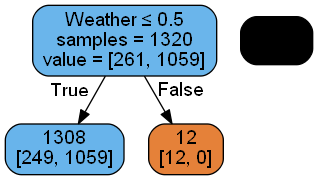

In [9]:
# fit the tree model and draw tree
smallClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

print('Tree has {} nodes'.format(smallClassTree.tree_.node_count))
plotDecisionTree(smallClassTree, feature_names=train_X.columns)

The limited tree has only one splitting variable: Weather

If (Weather <= 0.5) then classify as Ontime.


We cannot use this tree, because we must know the Weather. The redundant information is the day of week (Monday) and arrival airport (EWR). The tree requires knowing whether the weather was inclement or not. We may not know the weather in advance.

Fit the same tree as in (a), this time excluding the Weather predictor. Display both the resulting (small) tree and the full-grown tree. You will find that the small tree contains a single terminal node.

In [10]:
# remove variable Weather from the analysis
predictors1_df = predictors_df
columns = list(predictors_df.columns)
columns
columns.remove('Weather')
predictors1_df = predictors1_df[columns]
predictors1_df.columns

Index(['DISTANCE', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

Tree has 591 nodes


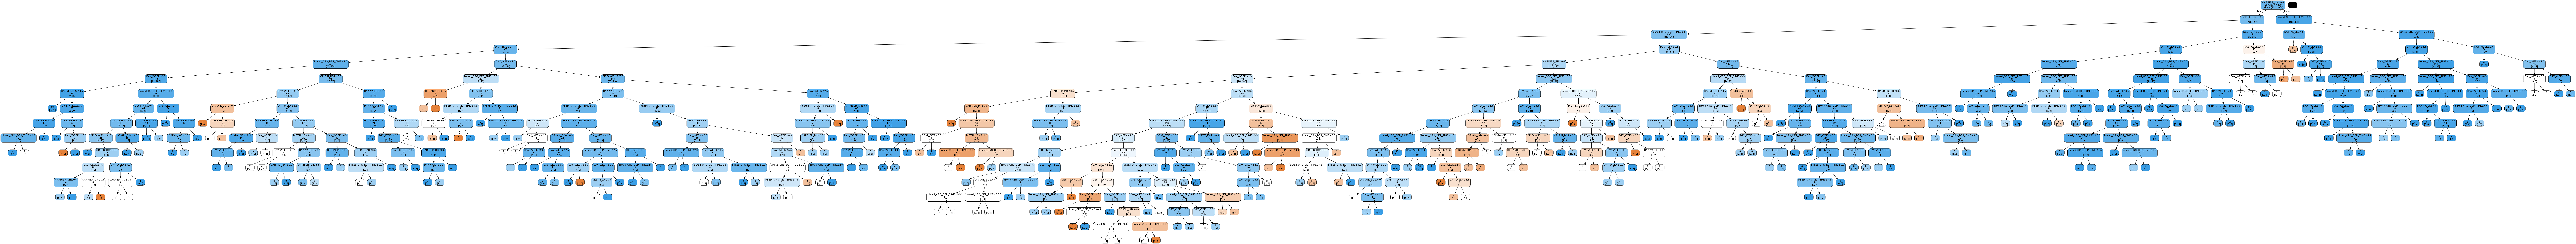

In [11]:
X1 = predictors1_df
y1 = delays_df['Flight Status']

train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1)

# full-grown tree
fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X1, train_y1)

print('Tree has {} nodes'.format(fullClassTree.tree_.node_count))
plotDecisionTree(fullClassTree, feature_names=train_X1.columns)

Tree has 1 nodes


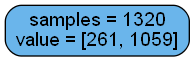

In [12]:
# small tree
ClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_impurity_decrease=0.01)
ClassTree.fit(train_X1, train_y1)

print('Tree has {} node(s)'.format(ClassTree.tree_.node_count))
plotDecisionTree(ClassTree, feature_names=train_X1.columns)